## Project-Specific Research
1. How many users do we have who have only made a purchase once
2. How many orders per month, on average, are not delivered for various reasons (itemize by reason)?   
3. For each product, determine on which day of the week the product is most often purchased.
4. How many purchases each user has on average per week (by month)?
5. Using pandas, conduct a cohort analysis of users. Identify the cohort with the highest retention for the 3rd month between January and December.
6.  Using Python, build an RFM-based user segmentation to assess your audience qualitatively.

In [7]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import timedelta
%matplotlib inline

In [8]:
orders = pd.read_csv('olist_orders_dataset.csv', 
                     parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                  'order_delivered_carrier_date', 'order_delivered_customer_date',
                                 'order_estimated_delivery_date'])

items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

customers = pd.read_csv('olist_customers_dataset.csv')

### 1. How many users do we have who have only made a purchase once?

Let's take only the data we consider as purchases from orders.

Since we consider `customer_unique_id` to be unique users, let's join the tables, having previously selected the necessary customer data.

In [9]:
purchases = orders.loc[orders.order_status.isin(['delivered', 'shipped'])]
purchases_users = customers[['customer_id', 'customer_unique_id']].merge(purchases, on='customer_id', how='left')

Let's count the number of purchases and get one-time ones.

In [10]:
one_purch = purchases_users.groupby('customer_unique_id', as_index = False).order_id.count().query("order_id == 1")
one_purch.shape

(91538, 2)

We obtained 91538 unique users. We can be sure that the users are unique because this field has already grouped the data.

We can also output the number of unique users to be sure.


In [11]:
one_purch.customer_unique_id.count()

91538

**Answer** - 91538

---

### 2. How many orders per month, on average, are not delivered for various reasons (itemized by reason)?

Let's select the data on orders that have yet to be delivered.

In [12]:
not_delivered = orders.loc[~(orders.order_status == 'delivered')].copy()

Let's take the date of purchase as the month. We will group by month and reason, count the number by month, then group again by reason, count the average for all months, and sort in descending order.

In [13]:
not_delivered['purch_my'] = not_delivered.order_purchase_timestamp.dt.to_period('M')
not_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purch_my
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,2018-08
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01


In [14]:
month_num = not_delivered.purch_my.nunique()

In [15]:
not_delivered_my = not_delivered.groupby('order_status', as_index=False).agg(orders=('order_id','count'))
not_delivered_my['per_month'] = not_delivered_my.orders / month_num
not_delivered_my = not_delivered_my.sort_values('per_month', ascending=False)
not_delivered_my

,order_status,orders,per_month
5,shipped,1107,46.125000
1,canceled,625,26.041667
6,unavailable,609,25.375000
3,invoiced,314,13.083333
4,processing,301,12.541667
2,created,5,0.208333
0,approved,2,0.083333


/var/folders/qp/pbljlgmj5vj88c5rdfd11b480000gn/T/ipykernel_7140/3966506739.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=not_delivered_my, x='order_status', y='per_month', palette='viridis')


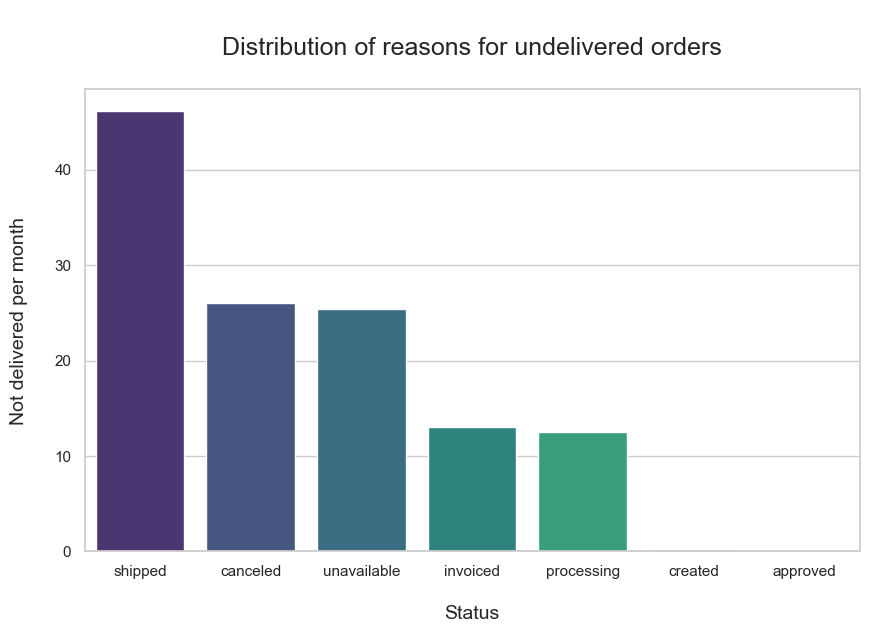

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(data=not_delivered_my, x='order_status', y='per_month', palette='viridis')

plt.xlabel('\nStatus', fontsize=14)
plt.ylabel('Not delivered per month\n', fontsize=14)
plt.title('\nDistribution of reasons for undelivered orders\n', fontsize=18)
plt.show()

Orders with `shipped` statuses are in transit, `invoiced` and `processing` - in process, `created` and `approved` were just created, so as `undelivered`, we will consider `canceled` and `unavailable` statuses.

**Answer**:
- About 25 orders on average per month are not delivered due to unavailability
- About 26 orders on average per month are not delivered due to cancellation

---

### 3. For each product, determine on which day of the week the product is most often purchased.

Let's add order dates to the items table.

In [17]:
items = items.merge(orders[['order_purchase_timestamp', 'order_id']], on='order_id')

Let's add a column with the day of the week to the items table.

In [18]:
items['weekday'] = items.order_purchase_timestamp.dt.strftime("%A")
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,Saturday


Group by `product_id` and `purch_weekday`, then count the number of purchases on each day of the week.

In [19]:
items_by_weekday = items.groupby(['product_id', 'weekday'], as_index=False) \
                        .agg({'order_purchase_timestamp': 'count'}) \
                        .rename(columns={'order_purchase_timestamp':'purchases'})
items_by_weekday.head()

,product_id,weekday,purchases
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


Let's leave only the days with the maximum number of purchases for each product. If there is more than one such day, we will display all of them, rename the columns, and remove brackets for better readability.

In [20]:
top_days = items_by_weekday[items_by_weekday['purchases'] == items_by_weekday['product_id'] \
                        .map(items_by_weekday.groupby('product_id').purchases.max())] \
                        .groupby('product_id', as_index=False).agg({'weekday': list, 'purchases': max}) \
                        .rename(columns={'weekday':'week_days', 'purchases':'max_purchases'})
top_days['week_days'] = top_days.week_days.apply(lambda x: ', '.join(x))
top_days.tail()

/var/folders/qp/pbljlgmj5vj88c5rdfd11b480000gn/T/ipykernel_7140/3060446887.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .groupby('product_id', as_index=False).agg({'weekday': list, 'purchases': max}) \


,product_id,week_days,max_purchases
32946,fff6177642830a9a94a0f2cba5e476d1,"Saturday, Sunday",1
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
32948,fff9553ac224cec9d15d49f5a263411f,Friday,1
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
32950,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1


**Answer**

Now we can refer to this table when we are interested in the shopping days of any products.

We can also see on which days more people buy in general.

In [21]:
weekdays_purch = items_by_weekday.groupby('weekday').purchases.sum().to_frame().reset_index()

/var/folders/qp/pbljlgmj5vj88c5rdfd11b480000gn/T/ipykernel_7140/4197647742.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday', y='purchases', data=weekdays_purch, order=weekday_order, palette='viridis')


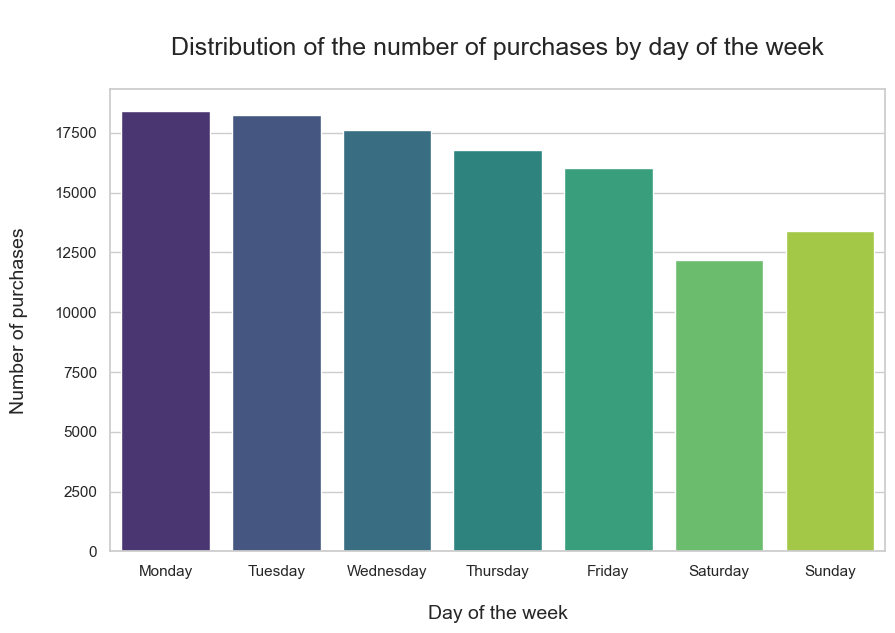

In [22]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x='weekday', y='purchases', data=weekdays_purch, order=weekday_order, palette='viridis')
plt.xlabel('\nDay of the week', fontsize=14)
plt.ylabel('Number of purchases\n', fontsize=14)
plt.title('\nDistribution of the number of purchases by day of the week\n', fontsize=18)
plt.show()

**Answer**

The most purchases are made on Monday, the least on Saturday.

To consider the top day for each product, we can refer to the table by product id.

---

### 4. How many purchases each user has on average per week (by month)? 
_Remember that there may be a partial number of weeks within a month. 
For example, November 2021 has 4.28 weeks. And within the metric, this needs to be accounted for._

Let's use the already created `purchases_users` table, which contains only the records we consider a purchase, as well as the unique ID of the customer.

In [23]:
f'''First purchase: {purchases_users.order_purchase_timestamp.min()}, last purchase:\
{purchases_users.order_purchase_timestamp.max()})'''


'First purchase: 2016-09-04 21:15:19, last purchase:2018-09-03 09:06:57)'

Let's add a column with the month.

In [24]:
purchases_users_month = purchases_users.assign(month=purchases_users['order_purchase_timestamp'].dt.to_period('M'))
purchases_users_month.head()


,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [25]:
purchases_users_month['first_or_last'] = purchases_users_month['month'].apply(lambda x: 'first' 
    if x == purchases_users_month['order_purchase_timestamp'].min()
    else ('last' if x == purchases_users_month['order_purchase_timestamp'].max() else ''))
purchases_users_month.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,first_or_last
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,


Let's calculate the number of weeks in months.

In [26]:
first_month_start = purchases_users_month[purchases_users_month['first_or_last'] == 'first']['order_purchase_timestamp'].min()
first_month_end = first_month_start + pd.offsets.MonthEnd(0)
num_weeks_first_month = (first_month_end - first_month_start).days / 7

num_weeks_last_month = purchases_users_month[purchases_users_month['first_or_last'] == 'last']['order_purchase_timestamp'].max().day / 7

purchases_users_month.loc[purchases_users_month['first_or_last'] == 'first', 'weeks'] = num_weeks_first_month
purchases_users_month.loc[purchases_users_month['first_or_last'] == 'last', 'weeks'] = num_weeks_last_month
purchases_users_month.loc[purchases_users_month['first_or_last'] == '', 'weeks'] = purchases_users_month['order_purchase_timestamp'].dt.daysinmonth/7
purchases_users_month.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,first_or_last,weeks
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,,4.428571


Group by unique ID and month, count the number of purchases each month first, then add a column with the number of purchases divided by the number of weeks each month.

In [27]:
monthly_purchases = purchases_users_month.groupby(['customer_unique_id', 'month'], as_index=False) \
                            .agg(total_purchases=('order_id', 'count'), weeks=('weeks', 'max'))
monthly_purchases = monthly_purchases.assign(purchases_weekly = monthly_purchases.total_purchases \
                                             /monthly_purchases['weeks'])
monthly_purchases.to_csv('monthly_purchases.csv')
monthly_purchases.sort_values('total_purchases', ascending=False).head()

,customer_unique_id,month,total_purchases,weeks,purchases_weekly
7191,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.428571,1.354839
75396,c8460e4251689ba205045f3ea17884a1,2018-08,4,4.428571,0.903226
23490,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.000000,1.000000
61056,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.000000,1.000000
49703,83e7958a94bd7f74a9414d8782f87628,2017-01,4,4.428571,0.903226


**Answer:** We can now refer to this table for each user's average weekly purchases by month.